 # Vehicle Routing Problem
 VRP with:
 - [x] Pickups and Deliveries Constraints
 - [x] Capacity Constraints
 - [x] Time Window Constraints
 - [x] Rescource Constraints
 - [x] Penalties And Dropping Visits

 ## Imports
 Import all the required libraries

In [1]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from matplotlib import pyplot as plt
import numpy as np

FROM_GOOGLE_MAPS = False

if FROM_GOOGLE_MAPS: 
    from distance_matrix_maps import data
else:
    from distance_matrix_manual import data


 ## Prepare the data
 Define model values

In [2]:
locations = np.array(data['locations'])
data['num_vehicles'] = 4
data['depot'] = 0 
data['vehicle_load_time'] = 5
data['vehicle_unload_time'] = 5
data['depot_capacity'] = 2


 Add pickup-delivery request

In [3]:
data['pickups_deliveries'] = [
    [1, 6],
    [2, 10],
    [4, 3],
    [5, 9],
    [7, 8],
    [15, 11],
    [13, 12],
    [16, 14],
]
data['pickups_deliveries']


[[1, 6], [2, 10], [4, 3], [5, 9], [7, 8], [15, 11], [13, 12], [16, 14]]

 Add Time Window for pickups.

In [4]:
data['time_windows'] = [
        (0, 5),     # depot
        (7, 12),    # 1
        (10, 15),   # 2
        (16, 18),   # 3
        (10, 13),   # 4
        (0, 5),     # 5
        (5, 10),    # 6
        (0, 4),     # 7
        (5, 10),    # 8
        (0, 3),     # 9
        (10, 16),   # 10
        (10, 15),   # 11
        (0, 5),     # 12
        (5, 10),    # 13
        (7, 8),     # 14
        (10, 15),   # 15
        (11, 15),   # 16
]
data['time_windows']


[(0, 5),
 (7, 12),
 (10, 15),
 (16, 18),
 (10, 13),
 (0, 5),
 (5, 10),
 (0, 4),
 (5, 10),
 (0, 3),
 (10, 16),
 (10, 15),
 (0, 5),
 (5, 10),
 (7, 8),
 (10, 15),
 (11, 15)]

 Add capacity request

In [5]:
MIN_LOAD_SIZE = 3
MAX_LOAD_SIZE = 8
data['vehicle_capacities'] = [15] * data['num_vehicles']
data['demands'] = [0] * len(data['locations'])
for (i, j) in data['pickups_deliveries']:
    demand = np.random.randint(MIN_LOAD_SIZE, MAX_LOAD_SIZE + 1)
    data['demands'][i] = demand
    data['demands'][j] = -demand + np.random.randint(MIN_LOAD_SIZE, MAX_LOAD_SIZE + 1)
data['demands']



[0, 6, 6, 1, 5, 8, -3, 8, -1, 0, 0, 0, -1, 4, 1, 8, 4]

 Create the routing index manager.

In [6]:
manager = pywrapcp.RoutingIndexManager(
    len(data['time_matrix']),
    data['num_vehicles'], 
    data['depot']
)


 ## Visualize the problem

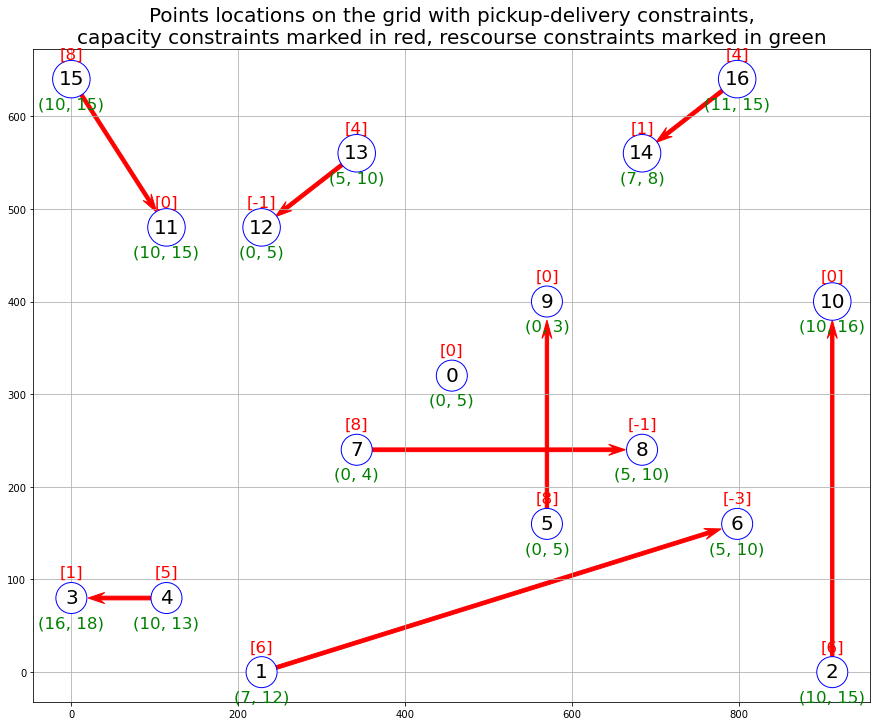

In [7]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(*locations.T)
marker_size = 20
for i, loc in enumerate(locations):
    ax.annotate(
        s=f"{i}", 
        xy=loc, 
        xycoords='data',
        va='center',
        ha='center',
        size=marker_size,
        bbox=dict(boxstyle='circle', fc='w', ec='b'))
    ax.annotate(
        s=f"[{data['demands'][i]}]", 
        xy=loc, 
        xytext=(0, marker_size + 5),
        xycoords='data',
        textcoords='offset points',
        va='center',
        ha='center',
        size=marker_size / 1.2,
        color='red')
    ax.annotate(
        s=f"{data['time_windows'][i]}", 
        xy=loc, 
        xytext=(0, -(marker_size + 5)),
        xycoords='data',
        textcoords='offset points',
        va='center',
        ha='center',
        size=marker_size / 1.2,
        color='green')
for pd_request in data['pickups_deliveries']:
    arrow = np.array([
        locations[pd_request[0]], 
        locations[pd_request[1]] - locations[pd_request[0]]
    ])
    arrow_length = np.linalg.norm(arrow[1])
    arrow_scale = (arrow_length - marker_size) / arrow_length
    ax.arrow(
        *arrow[0],
        *(arrow[1] * arrow_scale),
        color='red',
        width=4,
        head_width=12,
        head_length=20,
        overhang=.3,
        length_includes_head=True,
    )
ax.grid(which='both')
ax.set_title(
'''Points locations on the grid with pickup-delivery constraints,
capacity constraints marked in red, rescourse constraints marked in green''', 
    fontsize=20)
plt.show()


 ## Create Routing Model

In [8]:
routing = pywrapcp.RoutingModel(manager)


 ### Create and register a distance transit callback.

In [9]:
def distance_callback(from_index, to_index):
    """
    Returns the distance between the two nodes.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

distance_callback_index = routing.RegisterTransitCallback(distance_callback)


 ### Create and register a time transit callback.

In [10]:
def time_callback(from_index, to_index):
    """
    Returns the time between the two nodes.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

time_callback_index = routing.RegisterTransitCallback(time_callback)


 ### Define cost of each arc as time between two nodes.

In [11]:
routing.SetArcCostEvaluatorOfAllVehicles(time_callback_index)


 ### Create and register a capacity demand callback.

In [12]:
def demand_callback(from_index):
    """
    Returns the demand of the node.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)


 ### Add Distance constraint.

In [13]:
dimension_name = 'Distance'
routing.AddDimension(
    distance_callback_index,
    0,      # no slack
    3000,   # vehicle maximum travel distance
    True,   # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)


 ### Add Demand constraint.

In [14]:
dimension_name = 'Capacity'
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,                          # no slack
    data['vehicle_capacities'], # vehicle maximum capacities
    True,                       # start cumul to zero
    dimension_name)
demand_dimension = routing.GetDimensionOrDie(dimension_name)


 ### Add Time Window constraint.

In [15]:
dimension_name = 'Time'
routing.AddDimension(
    time_callback_index,
    30,     # allow waiting time
    30,     # maximum time per vehicle
    False,  # Don't force start cumul to zero.
    dimension_name)
time_dimension = routing.GetDimensionOrDie(dimension_name)


 Add time window constraints for each location except depot.

In [16]:
for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == 0:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])


 Add time window constraints for each vehicle start node.

In [17]:
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(*(data['time_windows'][0]))


 Add resource constraint at the depot.

In [18]:
solver = routing.solver()
intervals = []
for i in range(data['num_vehicles']):
    # Add time windows at start of routes
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.Start(i)),
            data['vehicle_load_time'], 'depot_interval'))
    # Add time windows at end of routes.
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.End(i)),
            data['vehicle_unload_time'], 'depot_interval'))


 Add depot usage to depot.

In [19]:
depot_usage = [1] * len(intervals)
solver.Add(
    solver.Cumulative(intervals, depot_usage, data['depot_capacity'], 'depot')
)


 Instantiate route start and end times to produce feasible times.

In [20]:
for i in range(data['num_vehicles']):
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.Start(i))
    )
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.End(i))
    )


## Define Transportation Requests for pickups and deliveries

In [21]:
for request in data['pickups_deliveries']:
    pickup_index = manager.NodeToIndex(request[0])
    delivery_index = manager.NodeToIndex(request[1])
    routing.AddPickupAndDelivery(pickup_index, delivery_index)
    routing.solver().Add(
        routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index)
    )
    routing.solver().Add(
        distance_dimension.CumulVar(pickup_index) <= distance_dimension.CumulVar(delivery_index)
    )


 ### Allow to drop nodes.

In [22]:
penalty = np.sum(data['distance_matrix']).item()
for node in range(1, len(data['distance_matrix'])):
    routing.AddDisjunction([manager.NodeToIndex(node)], penalty)


 ## Set first solution to heuristic.

In [23]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters


first_solution_strategy: PATH_CHEAPEST_ARC
local_search_operators {
  use_relocate: BOOL_TRUE
  use_relocate_pair: BOOL_TRUE
  use_relocate_neighbors: BOOL_FALSE
  use_exchange: BOOL_TRUE
  use_cross: BOOL_TRUE
  use_cross_exchange: BOOL_FALSE
  use_two_opt: BOOL_TRUE
  use_or_opt: BOOL_TRUE
  use_lin_kernighan: BOOL_TRUE
  use_tsp_opt: BOOL_FALSE
  use_make_active: BOOL_TRUE
  use_make_inactive: BOOL_TRUE
  use_make_chain_inactive: BOOL_FALSE
  use_swap_active: BOOL_TRUE
  use_extended_swap_active: BOOL_FALSE
  use_path_lns: BOOL_FALSE
  use_full_path_lns: BOOL_FALSE
  use_tsp_lns: BOOL_FALSE
  use_inactive_lns: BOOL_FALSE
  use_node_pair_swap_active: BOOL_TRUE
  use_relocate_and_make_active: BOOL_FALSE
  use_exchange_pair: BOOL_TRUE
  use_relocate_expensive_chain: BOOL_TRUE
  use_light_relocate_pair: BOOL_TRUE
  use_relocate_subtrip: BOOL_TRUE
  use_exchange_subtrip: BOOL_TRUE
  use_global_cheapest_insertion_path_lns: BOOL_TRUE
  use_local_cheapest_insertion_path_lns: BOOL_TRUE
  use

 ## Solve the problem.

In [24]:
solution = routing.SolveWithParameters(search_parameters)


 ## Print the solution
 - Display routes
 - Display dropped nodes

In [25]:
dropped_ids = []
if solution:
    # Display routes
    total_distance = 0
    global_max_load = 0
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        print(f'Route for vehicle {vehicle_id}:')
        route_distance = 0
        max_route_load = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            time_var = time_dimension.CumulVar(index)
            print(f' {node_index} Load({route_load}) --Time({solution.Min(time_var)}, {solution.Max(time_var)})-->')
            route_distance += data['distance_matrix'][node_index][manager.IndexToNode(index)]
            max_route_load = max(route_load, max_route_load)
        print(f'{manager.IndexToNode(index)} Load({route_load})\n')
        print(f'Distance of the route: {route_distance}m')
        print(f'Time of the route: {solution.Min(time_var)}min')
        total_distance += route_distance
        total_time += solution.Min(time_var)
        print(f'Max load of the route: {route_load}\n-------------')
        global_max_load = max(global_max_load, max_route_load)
    print(f'Total distance of all routes: {total_distance}m')
    print(f'Total time of all routes: {total_time}min')
    print(f'Maximum load for all vehicles: {global_max_load}')
    print('=====================')
    # Display dropped nodes.
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if solution.Value(routing.NextVar(node)) == node:
            dropped_ids.append(manager.IndexToNode(node))
    print(f'Dropped nodes: {dropped_ids if dropped_ids else None}')
else:
    print('No solution found')


Route for vehicle 0:
 0 Load(0) --Time(10, 10)-->
 2 Load(6) --Time(10, 10)-->
 10 Load(6) --Time(11, 11)-->
0 Load(6)

Distance of the route: 1712m
Time of the route: 11min
Max load of the route: 6
-------------
Route for vehicle 1:
 0 Load(0) --Time(0, 3)-->
 5 Load(8) --Time(0, 3)-->
 9 Load(8) --Time(10, 13)-->
 4 Load(13) --Time(16, 16)-->
 3 Load(14) --Time(17, 17)-->
0 Load(14)

Distance of the route: 2100m
Time of the route: 17min
Max load of the route: 14
-------------
Route for vehicle 2:
 0 Load(0) --Time(0, 4)-->
 7 Load(8) --Time(7, 9)-->
 1 Load(14) --Time(8, 10)-->
 6 Load(11) --Time(8, 10)-->
 8 Load(10) --Time(10, 10)-->
0 Load(10)

Distance of the route: 1780m
Time of the route: 10min
Max load of the route: 10
-------------
Route for vehicle 3:
 0 Load(0) --Time(5, 5)-->
 13 Load(4) --Time(5, 5)-->
 12 Load(3) --Time(10, 14)-->
 15 Load(11) --Time(10, 14)-->
 11 Load(11) --Time(15, 15)-->
0 Load(11)

Distance of the route: 1712m
Time of the route: 15min
Max load of th

 ## Visualize the solution

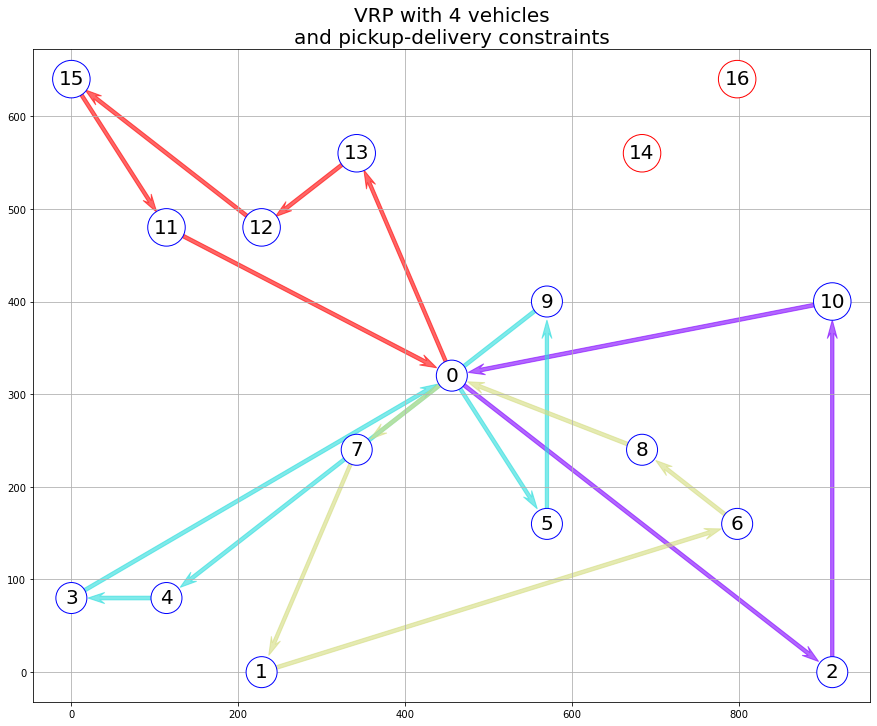

In [26]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(*locations.T)
marker_size = 20
for i, loc in enumerate(locations):
    ax.annotate(
        s=f"{i}", 
        xy=loc, 
        xycoords='data',
        va='center',
        ha='center',
        size=marker_size,
        bbox=dict(
            boxstyle='circle', 
            fc='w', 
            ec='blue' if i not in dropped_ids else 'red'
        )
    )
if solution:
    colors = plt.cm.rainbow(np.linspace(0, 1, data['num_vehicles']))
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        while not routing.IsEnd(index):
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            arrow = np.array([
                locations[manager.IndexToNode(previous_index)], 
                locations[manager.IndexToNode(index)] - locations[manager.IndexToNode(previous_index)]
            ])
            arrow_length = np.linalg.norm(arrow[1])
            arrow_scale = (arrow_length - marker_size) / arrow_length
            ax.arrow(
                *arrow[0],
                *(arrow[1] * arrow_scale),
                color=colors[vehicle_id],
                alpha=.6,
                label=f'Vehicle {vehicle_id}',
                width=4,
                head_width=12,
                head_length=20,
                overhang=.3,
                length_includes_head=True,
            )
    ax.grid(which='both')
    ax.set_title(f'VRP with {data["num_vehicles"]} vehicles\nand pickup-delivery constraints', fontsize=20)
    plt.show()
